<h1><center><b>Predicting Future Sales</b></center></h1>

## Import Libraries

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

%matplotlib inline

In [2]:
print(os.listdir('../input/competitive-data-science-predict-future-sales'))

['items.csv', 'sales_train.csv', 'item_categories.csv', 'test.csv', 'shops.csv', 'sample_submission.csv']


## Loading Data

In [3]:
DATA_DIR = '../input/competitive-data-science-predict-future-sales'
train = pd.read_csv(os.path.join(DATA_DIR,'sales_train.csv'))
items = pd.read_csv(os.path.join(DATA_DIR,'items.csv'))

In [4]:
train.shape

(2935849, 6)

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Data Analysis & Cleaning

### Merging sales and train data

In [6]:
train = pd.merge(train, items, on='item_id', how='left')
train = train.drop('item_name', axis=1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


### Forming the dataset of all possible combination of comm_col elements

Since our model has no records of those days when the sales were zero so we will form combination of all the values of the shop_id, item_id, block_num. And then merge this combined dataframe with train on these three values and fill the nan values with 0 thus providing 0 sales target data. 

In [8]:
com_cols = ['shop_id','item_id','date_block_num']

Using itertools.product function to form combinatorical permutations of all the unique values of shop_id, item_id according to date blocks.

In [9]:
comm = []
for block in train.date_block_num.unique():
    comm_shop = train.loc[train.date_block_num == block, 'shop_id'].unique()
    comm_item = train.loc[train.date_block_num == block, 'item_id'].unique()
    comm.append(np.array(list(itertools.product(*[comm_shop, comm_item, [block]])), dtype='int32'))
combined = pd.DataFrame(np.vstack(comm), columns=com_cols, dtype=np.int32)

In [10]:
combined.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Group by date_block_num, item_id, shop_id and aggregating target value according to its sum and item prices with mean

In [11]:
mean_train = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum', 'item_price':np.mean}).reset_index()

Merging the combined and aggregated train dataset.

In [12]:
mean_train = pd.merge(combined, mean_train, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [13]:
items = items.drop('item_name',axis=1)

In [14]:
mean_train = pd.merge(mean_train, items, on='item_id', how='left')
mean_train.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,59,2552,0,0.0,0.0,58
2,59,2554,0,0.0,0.0,58
3,59,2555,0,0.0,0.0,56
4,59,2564,0,0.0,0.0,59


### Creating mean encodings

Aggregating item_id, shop_id and item_category_id individually according to date_block_num. It is different from previous aggregation as it is applied individually on each and then forming the dataset with new features generated with the aggregation and then merging it with train dataset.

In [15]:
for type_id in ['item_id','shop_id','item_category_id']:
    for col_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        df = train.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[col_id,type_id,'date_block_num']]
        df.columns = [type_id+'_'+aggtype+'_'+col_id, type_id, 'date_block_num']
        mean_train = pd.merge(mean_train,df,on=['date_block_num',type_id], how='left')
        del df

In [16]:
mean_train.head(10)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,37,999.000000,18.0,1.000000,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,58,899.000000,0.0,0.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,58,1709.050000,1.0,1.000000,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,56,1098.850000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,59,327.600000,5.0,1.000000,820.174553,2017.0,1.092041,443.330014,701.0,0.990113
5,59,2565,0,0.0,0.0,56,549.000000,2.0,1.000000,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
6,59,2572,0,0.0,0.0,55,284.333333,12.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
7,59,2573,0,0.0,0.0,55,299.000000,16.0,1.142857,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
8,59,2574,0,2.0,399.0,55,392.986538,119.0,1.144231,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878
9,59,2593,0,0.0,0.0,55,254.200000,5.0,1.000000,820.174553,2017.0,1.092041,265.640547,12527.0,1.025878


In [17]:
del train
del combined

In [18]:
import gc
gc.collect()

64

### Creating lag features

lag features are created according to the lagged variables

In [19]:
lag_var = list(mean_train.columns[6:])+['item_cnt_day']
lags = [1,2]
for lag in lags:
    df = mean_train.copy()
    df.date_block_num += lag
    df = df[['date_block_num','shop_id','item_id'] + lag_var]
    df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat+'_lag_'+str(lag) for lag_feat in lag_var]
    mean_train = pd.merge(mean_train, df, on=['date_block_num','shop_id','item_id'], how='left')
    del df

In [20]:
mean_train.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,...,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2
0,59,22154,0,1.0,999.0,37,999.00,18.0,1.0,820.174553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,58,899.00,0.0,0.0,820.174553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,58,1709.05,1.0,1.0,820.174553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,56,1098.85,2.0,1.0,820.174553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,59,327.60,5.0,1.0,820.174553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Selecting rows having lagged features.

In [21]:
mean_train = mean_train[mean_train.date_block_num>4]

Filling missng values with 0

In [22]:
for feat in mean_train.columns:
    if 'item_cnt' in feat:
        mean_train[feat] = mean_train[feat].fillna(0)
    elif 'item_price' in feat:
        mean_train[feat] = mean_train[feat].fillna(mean_train[feat].median())

### Dropping non-lagged features

In [23]:
col_drop = lag_var[:-1] + ['item_price']
training = mean_train.drop(col_drop, axis=1)

In [24]:
gc.collect()

100

## Training

In [25]:
xgbdata = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)

In [26]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
bst = xgb.train(param, xgbdata)

[19:14:49] WARNING: ../src/learner.cc:516: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:49] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


### Plotting the feature importance

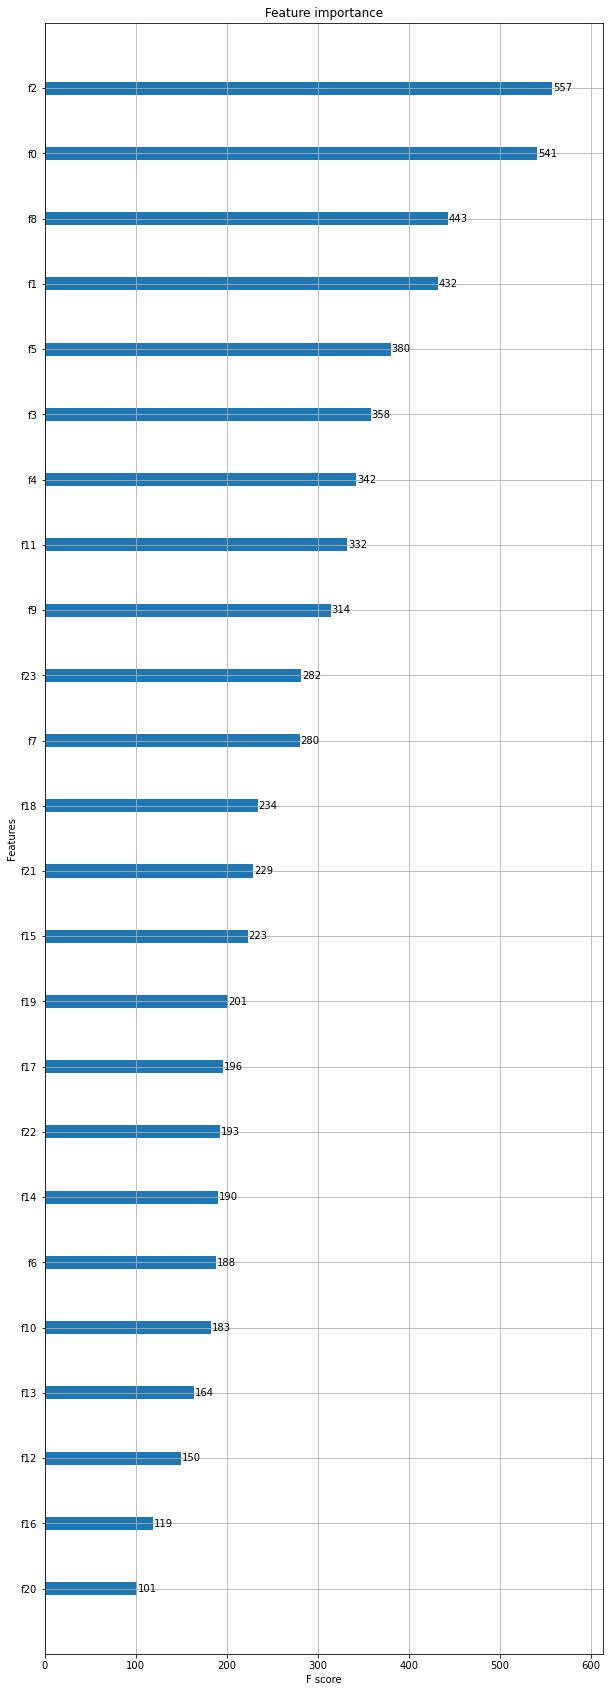

In [27]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30)

In [28]:
cols = list(training.columns)
del cols[cols.index('item_cnt_day')]

Columns with high feature importance

In [29]:
[cols[x] for x in [2, 0, 8, 1, 4, 5, 3, 11, 23]]

['date_block_num',
 'shop_id',
 'shop_id_sum_item_cnt_day_lag_1',
 'item_id',
 'item_id_avg_item_price_lag_1',
 'item_id_sum_item_cnt_day_lag_1',
 'item_category_id',
 'item_category_id_sum_item_cnt_day_lag_1',
 'item_cnt_day_lag_2']

In [30]:
training.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day',
       'item_category_id', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2'],
      dtype='object')

### Reading test data

In [31]:
test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))

In [32]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [33]:
test['date_block_num'] = 34

Merging with items dataframe

In [34]:
test = pd.merge(test, items, on='item_id', how='left')

### Creating lagged features

In [35]:
for lag in lags:
    df = mean_train.copy()
    df.date_block_num += lag
    df = df[['date_block_num','shop_id','item_id']+lag_var]
    df.columns = ['date_block_num','shop_id','item_id']+ [feat+'_lag_'+str(lag) for feat in lag_var]
    test = pd.merge(test,df,on=['date_block_num','shop_id','item_id'],how='left')
    del df

In [36]:
del mean_train
gc.collect()

20

In [37]:
test = test.drop('ID',axis=1)
training = training.drop('item_cnt_day',axis=1)

In [38]:
assert (list(training.columns) == list(test.columns))

In [39]:
for feat in test.columns:
    if 'item_cnt' in feat:
        test[feat]=test[feat].fillna(0)
    elif 'item_price' in feat:
        test[feat]=test[feat].fillna(test[feat].median())

## Prediction

In [40]:
xgbpreddata = xgb.DMatrix(test.values)

In [41]:
pred = bst.predict(xgbpreddata)

In [42]:
pd.Series(pred).describe()

count    214200.000000
mean          0.316315
std           2.789521
min         -67.149681
25%           0.052581
50%           0.116369
75%           0.247341
max         455.850525
dtype: float64

Clipping values as it was given in the competition

In [43]:
pred = pred.clip(0,20)

In [44]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })

In [45]:
sub_df.head()

,ID,item_cnt_month
0,0,0.456926
1,1,0.147750
2,2,0.965814
3,3,0.538423
4,4,3.746538


In [46]:
sub_df.to_csv('submission.csv',index=False)